# **Imports**

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Models**

## **Generator**

In [3]:
class GeneratorBlock(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, **kwargs):
        super(GeneratorBlock, self).__init__(**kwargs)
        self.sequential = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    

    def forward(self, X):
        return self.sequential(X)
    
    

In [4]:
class Generator(nn.Module):
    def __init__(self, size, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.sequential = nn.Sequential(
            GeneratorBlock(in_channels=100, out_channels=size*8, strides=1, padding=0),
            GeneratorBlock(in_channels=size*8, out_channels=size*4),
            GeneratorBlock(in_channels=size*4, out_channels=size*2),
            GeneratorBlock(in_channels=size*2, out_channels=size),
            nn.ConvTranspose2d(in_channels=size, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, X):
        return self.sequential(X)


## **Discriminator**

In [5]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, alpha=0.2, **kwargs):
        super(DiscriminatorBlock, self).__init__(**kwargs)
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha, inplace=True)
        )
    

    def forward(self, X):
        return self.sequential(X)
    
    

In [6]:
class Discriminator(nn.Module):
    def __init__(self, size, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.sequential = nn.Sequential(
            DiscriminatorBlock(size),
            DiscriminatorBlock(in_channels=size, out_channels=size*2),
            DiscriminatorBlock(in_channels=size*2, out_channels=size*4),
            DiscriminatorBlock(in_channels=size*4, out_channels=size*8),
            nn.Conv2d(in_channels=size*8, out_channels=1, kernel_size=4, bias=False)
        )
    

    def forward(self, X):
        return self.sequential(X)

## **Full GAN**

In [37]:
class GAN:
    def __init__(self, size):
        self.loss = None
        self.optim_generator = None
        self.optim_discriminator = None
        self.latent_dim = 100
        self.device = 'cuda'
        self.generator = Generator(size).to(self.device)
        self.discriminator = Discriminator(size).to(self.device)

    def load(self, checkpoint_path):
        self.discriminator.load_state_dict(torch.load(os.path.join(checkpoint_path, 'discriminator.pth')))
        self.generator.load_state_dict(torch.load(os.path.join(checkpoint_path, 'generator.pth')))


    def update_generator(self, Z):
        batch_size = Z.shape[0]
        ones = torch.ones((batch_size,), device=Z.device)

        self.optim_generator.zero_grad()

        X_fake = self.generator(Z)
        Y_fake = self.discriminator(X_fake)

        loss_generator = self.loss(Y_fake, ones.reshape(Y_fake.shape))

        loss_generator.backward()
        self.optim_generator.step()

        return loss_generator


    def update_discriminator(self, X, Z):
        batch_size = X.shape[0]
        ones = torch.ones((batch_size,), device=X.device)
        zeros = torch.zeros((batch_size,), device=X.device)
        
        self.optim_discriminator.zero_grad()

        Y_real = self.discriminator(X)
        X_fake = self.generator(Z)
        Y_fake = self.discriminator(X_fake.detach())

        loss_discriminator = (
            self.loss(Y_real, ones.reshape(Y_real.shape)) +
            self.loss(Y_fake, zeros.reshape(Y_fake.shape))
        ) / 2

        loss_discriminator.backward()
        self.optim_discriminator.step()

        return loss_discriminator


    def train(self, dataloader, num_epochs, lr, latent_dim, device, checkpoint_path=None):
        self.loss = nn.BCEWithLogitsLoss(reduction='sum')
        self.latent_dim = latent_dim
        self.device = device

        self.discriminator = self.discriminator.to(device)
        self.generator = self.generator.to(device)

        trainer_hp = {
            'lr' : lr,
            'betas' : [0.5, 0.999]
        }

        self.optim_discriminator = torch.optim.Adam(self.discriminator.parameters(), **trainer_hp)
        self.optim_generator = torch.optim.Adam(self.generator.parameters(), **trainer_hp)

        for epoch in range(1, num_epochs + 1):
            for idx, X in enumerate(dataloader):
                X = X.to(device)
                Z = torch.normal(0, 1, size=(X.shape[0], latent_dim, 1, 1)).to(device)

                loss_discriminator = self.update_discriminator(X, Z)
                loss_generator = self.update_generator(Z)

            print(f'Epoch {epoch}/{num_epochs} | Loss Discriminator = {loss_discriminator:3.5f} | Loss Generator = {loss_generator:3.5f}')

            if checkpoint_path:
                torch.save(self.discriminator.state_dict(), os.path.join(checkpoint_path, 'discriminator.pth'))
                torch.save(self.generator.state_dict(), os.path.join(checkpoint_path, 'generator.pth'))
    

    def generate(self):
        Z = torch.normal(0, 1, size=(1, self.latent_dim, 1, 1)).to(self.device)
        Y = self.generator(Z).to('cpu').detach()[0]
        Y_numpy = Y.numpy().transpose(1, 2, 0)
        return Y_numpy



# **Data**

## **Transform**

In [8]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

## **Dataset**

In [9]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, data_path, transform):
        self.data_path = data_path
        self.data_list = [os.path.join(data_path, file_name) for file_name in os.listdir(data_path)]
        self.transform = transform


    def __getitem__(self, index):
        file_name = self.data_list[index]
        raw_image = Image.open(file_name).convert('RGB')
        transformed_image = self.transform(raw_image)
        return transformed_image
    

    def __len__(self):
        return len(self.data_list)



In [10]:
dataset = ImageDataset('./data', transform)

## **Dataloader**

In [11]:
from torch.utils.data import DataLoader

batch_size = 32
loader = DataLoader(dataset, batch_size=batch_size)

# **Train**

In [14]:
model = GAN(64)

In [16]:
model.train(loader, 100, 0.005, 100, device, './models/model_1')

Epoch 1/100 | Loss Discriminator = 5.06863 | Loss Generator = 15.85511
Epoch 2/100 | Loss Discriminator = 2.29979 | Loss Generator = 20.18212
Epoch 3/100 | Loss Discriminator = 5.38093 | Loss Generator = 14.27090
Epoch 4/100 | Loss Discriminator = 4.33132 | Loss Generator = 17.03323
Epoch 5/100 | Loss Discriminator = 6.77500 | Loss Generator = 16.82803
Epoch 6/100 | Loss Discriminator = 7.51119 | Loss Generator = 24.44172
Epoch 7/100 | Loss Discriminator = 2.14064 | Loss Generator = 23.51208
Epoch 8/100 | Loss Discriminator = 5.09042 | Loss Generator = 19.59623
Epoch 9/100 | Loss Discriminator = 2.87524 | Loss Generator = 20.07358
Epoch 10/100 | Loss Discriminator = 5.29804 | Loss Generator = 33.63028
Epoch 11/100 | Loss Discriminator = 5.22002 | Loss Generator = 19.49815
Epoch 12/100 | Loss Discriminator = 6.21563 | Loss Generator = 27.49971
Epoch 13/100 | Loss Discriminator = 3.41900 | Loss Generator = 13.62777
Epoch 14/100 | Loss Discriminator = 4.42697 | Loss Generator = 32.68762
E

# **Visualize**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

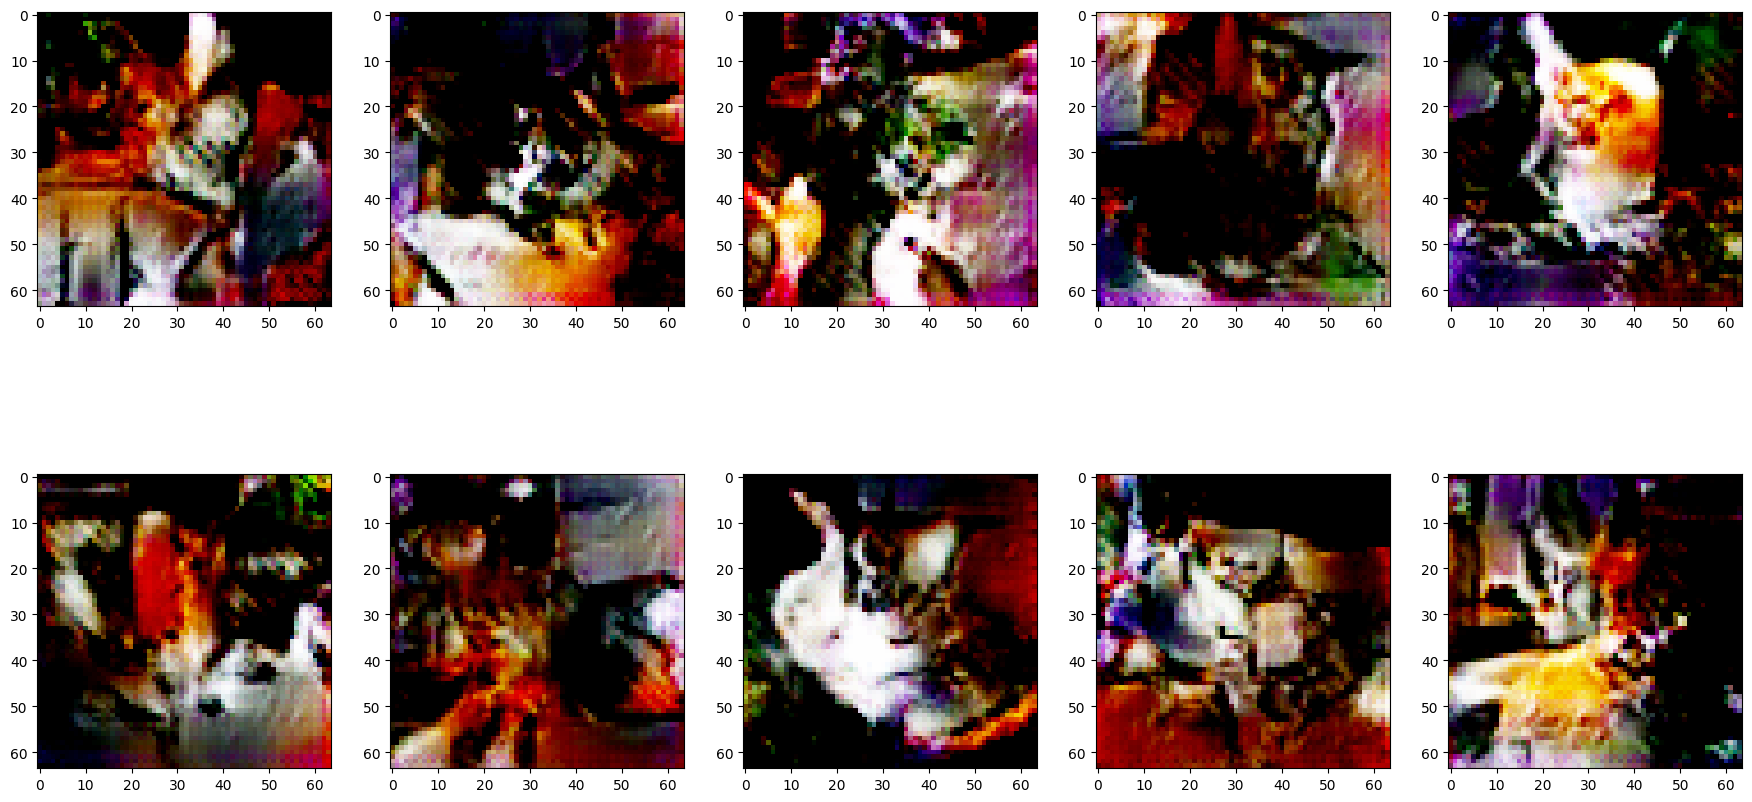

In [79]:
fig, axs = plt.subplots(2, 5, figsize=(22,11))

for i in range(2):
    for j in range(5):
        axs[i][j].imshow(model.generate())

fig.show()